('Shape', (133,))
Signal Min/Max: 1.73112261295 1.7580395937
Total Patterns:  107
Building LSTM network...
Picking a noisy seed...
INIT pattern is [5, 13, 21, 29, 37, 44, 49, 48, 47, 43, 43, 41, 37, 40, 45, 51, 58, 63, 67, 53, 47, 48, 40, 35, 40]
Generating Sequence....

Done.
Original Signal:


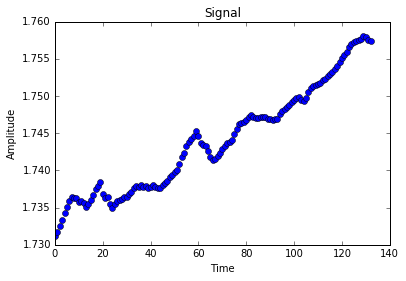

Input Seed Pattern:


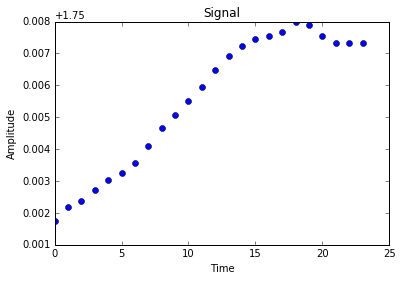

Generated Signal:


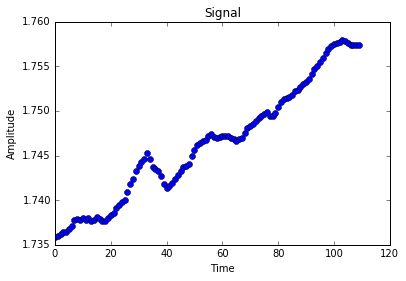

Input + predicted signal


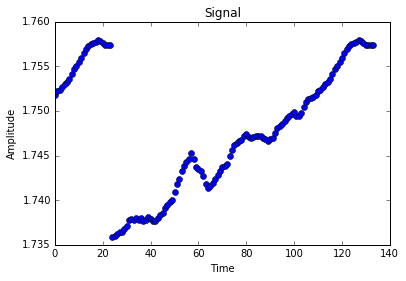

In [23]:
"""
Predict time sequences using
Trained Dyn Stall Inception data
(training weights being generated elsewhere, like Godzilla)
"""
import sys
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

def plot_data(data):
    plt.plot(data,'o')
    plt.title('Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def downsample(data, n_points):
    """ downsample every 'n' points """
    new_data = data[0:-1:n_points]
    return new_data
    
def define_states(data, n_states):
    """ Define bounds for each state """
    data_lowbound = np.min(data)
    data_highbound = np.max(data)
    print('Signal Min/Max:', data_lowbound, data_highbound)
    data_span = data_highbound - data_lowbound
    state_window = data_span/n_states
    lbound = []
    ubound = []
    state_id = []
    for i in range(n_states):
        state_id.append(i)
        lbound.append(data_lowbound + (i*state_window))
        ubound.append(data_lowbound + ((i+1)*state_window))
        
    state_boundaries = list(zip(state_id,lbound,ubound))
    return state_boundaries
    
def create_states(data, state_boundaries):
    """ identify states in the signal """
    states = []
    sig_len = len(data)
    #print(sig_len)
    for i in range(0,sig_len):
        #print(i)
        dataPoint = data[i]
        #print(dataPoint)
        for j in range(len(state_boundaries)):
            if (dataPoint > state_boundaries[j][1] \
                and dataPoint <= state_boundaries[j][2]):
                states.append(state_boundaries[j][0])
                #print(state_boundaries[j][0])
                break
    return states        


def signal_convert(dat, state_boundaries):
    rawSignal=[]
    datlen = len(dat)
    #print('len', datlen)
    for i in range(0,datlen-1):
        #print('i is', i)
        ind = dat[i]
        #print('index', ind)
        temp = 0.5*(state_boundaries[ind][1] + state_boundaries[ind][2])
        rawSignal.append(temp)
        #print('aa is', temp)
    
    return rawSignal


def generate_noisy_seed(data, state_boundaries, SNR):
    signal = map_to_signal(data, state_boundaries)
    noise = np.random.normal(0, 1, len(signal))*(1.0/SNR)
    noisy_signal = signal + noise
    noise_state_signal = create_states(noisy_signal, state_boundaries)
    return noise_state_signal
    
    
    
""" 
Read Data
 
"""

inputData = np.load('dynStallTrainingData.npy')
print(('Shape', inputData.shape))   

#xinp = np.linspace(-np.pi, 8*np.pi, 201)
#inputData = np.sin(xinp)
#print('Shape', inputData.shape)  
    
"""
Main Code
"""
# INPUT
n_states = 250
seq_length = 25
# load the network weights
filename = "weights_case3_r5.hdf5"

state_boundaries = define_states(inputData, n_states)
states = create_states(inputData, state_boundaries)    
# prepare the dataset of input to output pairs encoded as integers
dataX = []
dataY = []
for i in range(0, len(states) - seq_length, 1):
	seq_in = states[i:i + seq_length]
	seq_out = states[i + seq_length]
	dataX.append(seq_in)
	dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
    
    
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_states)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
# Train Neural Nets
print('Building LSTM network...')
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam') 


model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')
# pick a random seed from input
#start = np.random.randint(0, len(dataX)-1)
#pattern = dataX[start]

print('Picking a noisy seed...')
#np.random.seed(12)
start = np.random.randint(0, len(dataX)-1)
start=0
pattern = dataX[start]
print('INIT pattern is', pattern)
# convert pattern to signal
#patternSignal = signal_convert(pattern,state_boundaries)
#print('Input Seed Pattern:')
#plot_data(patternSignal)
#print 'Picking a noisy seed...'
#SNR = 10
#noisyPattern = generate_noisy_seed(purePattern, state_boundaries, SNR)
#print "Seed:"
#print "\"", pattern , "\""
print('Generating Sequence....')
predict_length = 110
# generate characters
predicted_signal=[]
for i in range(predict_length):
    x = np.reshape(pattern, (1, len(pattern), 1))
    #print('x is', x)
    x = x / float(n_states)
    #print('xmod is', x)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = 0.5*(state_boundaries[index][1] + state_boundaries[index][2])
    #print result
    predicted_signal.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

# convert pattern to signal
patternSignal = signal_convert(pattern,state_boundaries)

# final prediction
finalPrediction = patternSignal + predicted_signal

"""
print('Seed ID is', start)
print('FINAL pattern is', pattern)
print('data at Seed ID', dataX[start])
"""
print('Original Signal:')
plot_data(inputData)
print('Input Seed Pattern:')
plot_data(patternSignal)
print('Generated Signal:')
plot_data(predicted_signal)
print('Input + predicted signal')
plot_data(finalPrediction)

In [ ]:
""" 
RESEARCH NOTES -
SUMMARY OF RESULTS
The signal downsampled by a factor of 3 is by far the best value on money - less wall time and enough resolution.
Shall stick to this henceforth.
250 states and 15000 epochs give bettr results -> increasing states is akin to increasing resolution, but it needs 
a lot more epochs to converge.
However, the effects of sequence length have to be studied. What is the LEAST we can have without compromising 
accuracy? How much wall time do we need?

Experiment with different cases:
1) 250 states with 15000 epochs, but seq. length = 25. keep batch size same
2) 250 states with 15000 epochs, but seq. length = 25. keep batch size 1/2 as before.


"""


In [ ]:
""" DOWNSAMPING DATASET"""

import numpy as np
import h5py
import time
#import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

start_time = time.time()

   
"""
Functions
"""  
"""
def plot_data(data):
    plt.plot(data,'o')
    plt.title('Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
"""

def downsample(data, n_points):
    """ downsample every 'n' points """
    new_data = data[0:-1:n_points]
    return new_data
    
def define_states(data, n_states):
    """ Define bounds for each state """
    data_lowbound = np.min(data)
    data_highbound = np.max(data)
    print('Signal Min/Max:', data_lowbound, data_highbound)
    data_span = data_highbound - data_lowbound
    state_window = data_span/n_states
    lbound = []
    ubound = []
    state_id = []
    for i in range(n_states):
        state_id.append(i)
        lbound.append(data_lowbound + (i*state_window))
        ubound.append(data_lowbound + ((i+1)*state_window))
        
    state_boundaries = list(zip(state_id,lbound,ubound))
    return state_boundaries
    
def create_states(data, state_boundaries):
    """ identify states in the signal """
    states = []
    sig_len = len(data)
    for i in range(sig_len):
        dataPoint = data[i]
        #print dataPoint
        for j in range(len(state_boundaries)):
            if (dataPoint > state_boundaries[j][1] \
                and dataPoint <= state_boundaries[j][2]):
                states.append(state_boundaries[j][0])
                break
    return states            
    
    
""" 
Read Data
 
"""

inputData = np.load('dynStallInception.npy')
print('Shape', inputData.shape)   

"""
Main Code
"""
# INPUT
n_states = 100
seq_length = 75
num_epochs = 1000
batch_size = 16
    
# plot data
print('input signal:')
plt.plot(inputData)    
plt.show()
downsamp_signal = downsample(inputData, 2)
plt.plot(downsamp_signal)
plt.show()
print('Downsampled Shape', downsamp_signal.shape)  

state_boundaries = define_states(downsamp_signal, n_states)
states = create_states(downsamp_signal, state_boundaries)    
# prepare the dataset of input to output pairs encoded as integers
dataX = []
dataY = []
for i in range(0, len(states) - seq_length, 1):
	seq_in = states[i:i + seq_length]
	seq_out = states[i + seq_length]
	dataX.append(seq_in)
	dataY.append(seq_out)
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)
print("dataX and Y are", len(dataX), len(dataY))

np.save('dynStallInceptionDown2',downsamp_signal)
    

In [5]:
finalPrediction = np.concatenate((patternSignal,predicted_signal), axis=0)

ValueError: setting an array element with a sequence.

In [12]:
finalPrediction = patternSignal + predicted_signal
len(finalPrediction)
len(patternSignal)
len(predicted_signal)
print(finalPrediction)

[1.7521716918945311, 1.7523870277404785, 1.7527100315093995, 1.7530330352783203, 1.7532483711242675, 1.7535713748931885, 1.7541097145080566, 1.7546480541229248, 1.7550787258148193, 1.7555093975067138, 1.7559400691986085, 1.7564784088134766, 1.7569090805053711, 1.7572320842742921, 1.7574474201202392, 1.7575550880432129, 1.7576627559661866, 1.7579857597351074, 1.7578780918121337, 1.7575550880432129, 1.7573397521972656, 1.7573397521972656, 1.7573397521972656, 1.7573397521972656, [1.7360215034484863, 1.7362368392944336, 1.7364521751403807, 1.7364521751403807, 1.7367751789093018, 1.7370981826782226, 1.7377441902160644, 1.7378518581390381, 1.7377441902160644, 1.7379595260620118, 1.7377441902160644, 1.7379595260620118, 1.7376365222930907, 1.7377441902160644, 1.7380671939849854, 1.7378518581390381, 1.7376365222930907, 1.7376365222930907, 1.7379595260620118, 1.7382825298309326, 1.7386055335998536, 1.7391438732147217, 1.7394668769836426, 1.7397898807525634, 1.7400052165985107, 1.7408665599822999

In [19]:
print(start)

90


In [22]:
dataX[90]

[144,
 146,
 147,
 152,
 157,
 159,
 161,
 164,
 167,
 170,
 172,
 174,
 170,
 169,
 173,
 179,
 184,
 187,
 188,
 189,
 191,
 195,
 197,
 200,
 203,
 205]

In [2]:
return_sequences

NameError: name 'return_sequences' is not defined